# <font color="chillipepper">**Imports and Installation**</font>

In [ ]:
!pip install yfinance

In [ ]:
import os

import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

import numpy as np
from datetime import datetime
import time
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import torch
import torch.nn as nn
from torch.nn import functional
from torch.nn.utils import spectral_norm
import torch.utils.data
import torch.utils.data.distributed
from torch import autograd
from torch.optim import Adam

In [ ]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, kurtosis
from scipy.optimize import fmin
from scipy.special import lambertw
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# <font color="chillipepper">**Class GANs**</font>

## <font color="chillipepper">**Temporal Block**</font>

TemporalBlock

A temporal block consists of 2 dilated causal convolutions, and 2 PReLUs as activation function.

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, dilation, hidden_dim_skip, num_inner_blocks=2, batch_norm=False, conditional_batch_norm=False,):

        super(TemporalBlock, self).__init__()
        self.drop_left = num_inner_blocks * (kernel_size - 1) * dilation
        ops = []  # initialize inner blocks
        in_dim = input_dim
        for i in range(num_inner_blocks):
            ops.append(spectral_norm(nn.Conv1d(
                        in_dim,
                        output_dim,
                        kernel_size=kernel_size,
                        stride=1,
                        padding=0,
                        dilation=dilation)))
            ops.append(nn.PReLU())
            if batch_norm:
                ops.append(nn.BatchNorm1d(output_dim))
            in_dim = output_dim
        self.block_ops = nn.Sequential(*ops)  # chain up both blocks with sequential
        if conditional_batch_norm:
            self.cbn = CondBatchNorm1d(output_dim)
        if hidden_dim_skip > 0:  # check if the net has a skip connection
            self.conv_1x1_skip = spectral_norm(nn.Conv1d(output_dim, hidden_dim_skip, kernel_size=1, stride=1))
        if input_dim != output_dim:
          self.downsample = nn.Conv1d(input_dim, output_dim, 1)
        else:
          self.downsample = None
        self.relu = nn.PReLU()

    def forward(self, inputs):
      x, skip, domain = inputs
      F_x = self.block_ops(x)

      if self.downsample is not None:
        x = self.downsample(x)

      # Align temporal dimensions between F_x and x
      if F_x.size(2) > x.size(2) - self.drop_left:
        F_x = F_x[..., :x.size(2) - self.drop_left]
      elif F_x.size(2) < x.size(2) - self.drop_left:
        pad_len = (x.size(2) - self.drop_left) - F_x.size(2)
        F_x = F.pad(F_x, (0, pad_len))

      F_x = F_x + x[:, :, self.drop_left:]

      # Fix skip connection shape mismatch
      skip_part = self.conv_1x1_skip(F_x)

      if skip.size(2) != skip_part.size(2):
        # Crop or pad skip_part to match skip size
        min_len = min(skip.size(2), skip_part.size(2))
        skip = skip[..., -min_len:] + skip_part[..., -min_len:]
      else:
        skip = skip + skip_part

      return self.relu(F_x), skip, domain

Convolution Batch 1D used in TCN

In [ ]:
class CondBatchNorm1d(nn.Module):
  def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True, num_domains=2):
    super(CondBatchNorm1d, self).__init__()
    self.num_features = num_features
    self.bns = []
    self.num_domains = num_domains
    for i in range(num_domains):
      self.bns.append(nn.BatchNorm1d(num_features, eps, momentum, affine, track_running_stats))
      self.bns[i].weight.data.fill_(1)
      self.bns[i].bias.data.zero_()

  def forward(self, x, domain):
    if type(self.bns) == list:
      self.bns = nn.ModuleList(self.bns)
      if x.is_cuda:
        self.bns.cuda()
    return self.bns[domain](x)

## <font color="chillipepper">**TCNs**</font>

Temporal Convolutional Networks

A TCN consists of dilated, causal 1D convolutional layers with the same input and output lengths.

In [ ]:
class TCN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, hidden_dim_skip=50, num_inner_blocks=2, dilation_factor=2, block_1x1=True, kernel_size=2, batch_norm=False, conditional_batch_norm=False,):
        super(TCN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim_skip = hidden_dim_skip
        hidden_dims = deepcopy(hidden_dims)
        layers = []

        if block_1x1:
            hidden_dims.insert(0, hidden_dims[0])

        num_blocks = len(hidden_dims)
        for i in range(num_blocks):
            if block_1x1:
                if i == 0:
                    dilation_size = 1
                else:
                    dilation_size = dilation_factor ** (i - 1)
            else:
                dilation_size = dilation_factor ** i
            if (block_1x1 and i == 0):
              ks = 1
            else:
               ks = kernel_size
            if i == 0:
              in_channels = input_dim
            else:
               in_channels = hidden_dims[i - 1]
            out_channels = hidden_dims[i]
            layers += [
                TemporalBlock(
                    input_dim=in_channels,
                    output_dim=out_channels,
                    kernel_size=ks,
                    num_inner_blocks=num_inner_blocks,
                    dilation=dilation_size,
                    hidden_dim_skip=hidden_dim_skip,
                    batch_norm=batch_norm,
                    conditional_batch_norm=conditional_batch_norm,)]
        self.num_blocks = num_blocks
        self.network = nn.Sequential(*layers)
        self.network_out = nn.Sequential(
            nn.PReLU(),
            spectral_norm(nn.Conv1d(hidden_dim_skip, hidden_dim_skip, kernel_size=1)),
            nn.PReLU(),
            spectral_norm(nn.Conv1d(hidden_dim_skip, output_dim, kernel_size=1)))

    def forward(self, x, domain=None):
        x = x.permute(0, 2, 1)
        skip = get_empty_skip_vector(x, self.hidden_dim_skip, self.receptive_field_size).to(x.device)
        x, skip, _ = self.network((x, skip, domain))
        x = self.network_out(skip).permute(0, 2, 1)
        return x

    @property
    def receptive_field_size(self):
        drop = 1
        for block in self.network:
            drop += block.drop_left
        return drop

In [ ]:
def get_empty_skip_vector(x, hidden_dim_skip, receptive_field_size):
  return torch.zeros(x.size(0), hidden_dim_skip, x.size(2) + receptive_field_size - 1)

## <font color="chillipepper">**Training G/D**</font>

Generative Adversial Networks

A GAN consists of two neural networks (Generator and Discriminator) competiting against each other.The Generator will try to fool the Discriminator by generating fake but realistic outputs given the inputs. While the Discriminator will try to attest wether the input received is a real or a fake one.

In [ ]:
def to_numpy(x):
    return x.cpu().detach().numpy()

class Trainer(object):
    def __init__(
            self,
            G,
            D,
            G_optimizer,
            D_optimizer,
            r1_gamma,
            r2_gamma,
            test_metrics,):
        self.G = G
        self.D = D
        self.G_optimizer = G_optimizer
        self.D_optimizer = D_optimizer

        self.r1_gamma = r1_gamma
        self.r2_gamma = r2_gamma

        self.test_metrics = test_metrics

    def compute_test_metrics(self, x_fake):
        test_metrics = list()
        losses = list()
        for aux_loss in self.test_metrics:
            with torch.no_grad():
                loss = aux_loss(x_fake)
            test_metrics.append((aux_loss.name, to_numpy(loss)))
        return test_metrics, losses

    def G_trainstep(self, z):
        toggle_grad(self.G, True)
        toggle_grad(self.D, False)
        self.G_optimizer.zero_grad()
        x_fake = self.G(z)
        d_fake = self.D(x_fake, domain=1)
        gloss = self.compute_loss(d_fake, 1)

        aux_loss_log, losses = self.compute_test_metrics(x_fake)
        success = all([aux_loss.success.item() for aux_loss in self.test_metrics])
        if not success:
            gloss.backward()
            self.G_optimizer.step()
        return gloss.item(), aux_loss_log, success

    def D_trainstep(self, x_real, z):
        toggle_grad(self.G, False)
        toggle_grad(self.D, True)
        self.D_optimizer.zero_grad()
        x_real.requires_grad_()
        d_real = self.D(x_real, domain=0)
        dloss_real = self.compute_loss(d_real, 1)
        with torch.no_grad():
            x_fake = self.G(z)
        x_fake.requires_grad_()
        d_fake = self.D(x_fake, domain=1)
        dloss_fake = self.compute_loss(d_fake, 0)
        reg_real, reg_fake = self.compute_regularizer(d_real, d_fake, x_real, x_fake)
        dloss_real.backward()
        dloss_fake.backward()
        self.D_optimizer.step()
        toggle_grad(self.D, False)
        return dloss_real.item(), dloss_fake.item(), reg_real.item(), reg_fake.item()

    def compute_regularizer(self, d_real, d_fake, x_real, x_fake):
        reg_1 = torch.tensor(0.)
        reg_2 = torch.tensor(0.)
        if self.r1_gamma > 0.0:
            reg_1 = self.r1_gamma * compute_grad2(d_fake, x_fake).mean()
            reg_1.backward(retain_graph=True)
        if self.r2_gamma > 0.0:
            reg_2 = self.r2_gamma * compute_grad2(d_real, x_real).mean()
            reg_2.backward(retain_graph=True)
        return reg_1, reg_2

    @staticmethod
    def compute_loss(d_out, target):
        targets = d_out.new_full(size=d_out.size(), fill_value=target)
        loss = functional.binary_cross_entropy_with_logits(d_out, targets)
        return loss

def toggle_grad(model, requires_grad):
    for p in model.parameters():
        p.requires_grad_(requires_grad)


def compute_grad2(d_out, x_in):
    batch_size = x_in.size(0)
    grad_dout = autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert (grad_dout2.size() == x_in.size())
    reg = grad_dout2.view(batch_size, -1).sum(1)
    return reg

## <font color="chillipepper">**Evaluation**</font>

In [ ]:
def acf_torch(x, max_lag, dim=(0, 1)):
    acf_list = list()
    x = x - x.mean((0, 1))
    std = torch.var(x, unbiased=False, dim=(0, 1))
    for i in range(max_lag):
        y = x[:, i:] * x[:, :-i] if i > 0 else torch.pow(x, 2)
        acf_i = torch.mean(y, dim) / std
        acf_list.append(acf_i)
    if dim == (0, 1):
        return torch.stack(acf_list)
    else:
        return torch.cat(acf_list, 1)


def cacf_torch(x, max_lag, dim=(0, 1)):
    def get_lower_triangular_indices(n):
        return [list(x) for x in torch.tril_indices(n, n)]

    ind = get_lower_triangular_indices(x.shape[2])
    x = (x - x.mean(dim, keepdims=True)) / x.std(dim, keepdims=True)
    x_l = x[..., ind[0]]
    x_r = x[..., ind[1]]
    cacf_list = list()
    for i in range(max_lag):
        y = x_l[:, i:] * x_r[:, :-i] if i > 0 else x_l * x_r
        cacf_i = torch.mean(y, (1))
        cacf_list.append(cacf_i)
    # if dim == (0, 1):
    #    return torch.stack(cacf_list)
    # else:
    cacf = torch.cat(cacf_list, 1)
    return cacf.reshape(cacf.shape[0], -1, len(ind[0]))


def lev_eff_torch(x, max_lag, dim=(0, 1)):
    lev_eff = list()
    x = x - x.mean((0, 1))

    mu = x.mean((0, 1))
    mu_pow = torch.abs(x).mean((0, 1))
    std = torch.std(x, unbiased=False, dim=(0, 1))
    std_pow = torch.std(torch.abs(x), unbiased=False, dim=(0, 1))

    for i in range(max_lag):
        if i > 0:
            y = (torch.abs(x[:, i:]) - mu_pow) * (x[:, :-i] - mu)
        else:
            y = (torch.abs(x) - mu_pow) * (x - mu)
        l_i = torch.mean(y, dim) / (std * std_pow)
        lev_eff.append(l_i)
    if dim == (0, 1):
        return torch.stack(lev_eff)
    else:
        return torch.cat(lev_eff, 1)


def skew_torch(x, dim=(0, 1), dropdims=True):
    x = x - x.mean(dim, keepdims=True)
    x_3 = torch.pow(x, 3).mean(dim, keepdims=True)
    x_std_3 = torch.pow(x.std(dim, unbiased=True, keepdims=True), 3)
    skew = x_3 / x_std_3
    if dropdims:
        skew = skew[0, 0]
    return skew


def kurtosis_torch(x, dim=(0, 1), excess=True, dropdims=True):
    x = x - x.mean(dim, keepdims=True)
    x_4 = torch.pow(x, 4).mean(dim, keepdims=True)
    x_var2 = torch.pow(torch.var(x, dim=dim, unbiased=False, keepdims=True), 2)
    kurtosis = x_4 / x_var2
    if excess:
        kurtosis = kurtosis - 3
    if dropdims:
        kurtosis = kurtosis[0, 0]
    return kurtosis


class Loss(nn.Module):
    def __init__(self, name, reg=1, transform=lambda x: x, inverse_transform=lambda x: x, threshold=10., norm_foo=lambda x: x):
        super(Loss, self).__init__()
        self.name = name
        self.reg = reg
        self.transform = transform
        self.threshold = threshold
        self.norm_foo = norm_foo
        self.inverse_transform = inverse_transform

    def forward(self, x_fake):
        self.loss_componentwise = self.compute(x_fake)
        return self.reg * self.loss_componentwise.mean()

    def compute(self, x_fake):
        raise NotImplementedError()

    @property
    def success(self):
        return torch.all(self.loss_componentwise <= self.threshold)


acf_diff = lambda x: torch.sqrt(torch.pow(x, 2).sum(0))
cc_diff = lambda x: torch.abs(x).sum(0)


class ACFLoss(Loss):
    def __init__(self, x_real, max_lag=64, **kwargs):
        super(ACFLoss, self).__init__(norm_foo=acf_diff, **kwargs)
        self.acf_real = acf_torch(self.transform(self.inverse_transform(x_real)), max_lag, dim=(0, 1))
        self.max_lag = max_lag

    def compute(self, x_fake):
        acf_fake = acf_torch(self.transform(self.inverse_transform(x_fake)), self.max_lag)
        return self.norm_foo(acf_fake - self.acf_real.to(x_fake.device))


class LevEffLoss(Loss):
    def __init__(self, x_real, max_lag=16, **kwargs):
        super(LevEffLoss, self).__init__(norm_foo=acf_diff, **kwargs)
        self.lef_eff_real = lev_eff_torch(self.inverse_transform(x_real), max_lag)
        self.max_lag = max_lag

    def compute(self, x_fake):
        acf_fake = lev_eff_torch(self.transform(self.inverse_transform(x_fake)), self.max_lag)
        return self.norm_foo(acf_fake - self.lef_eff_real.to(x_fake.device))


class MeanLoss(Loss):
    def __init__(self, x_real, **kwargs):
        super(MeanLoss, self).__init__(norm_foo=torch.abs, **kwargs)
        self.mean_real = self.inverse_transform(x_real).mean((0, 1))

    def compute(self, x_fake):
        return self.norm_foo(self.inverse_transform(x_fake).mean((0, 1)))


class StdLoss(Loss):
    def __init__(self, x_real, **kwargs):
        super(StdLoss, self).__init__(norm_foo=torch.abs, **kwargs)
        self.std_real = self.inverse_transform(x_real).std((0, 1))

    def compute(self, x_fake):
        std_fake = self.inverse_transform(x_fake).std((0, 1))
        return self.norm_foo(std_fake - self.std_real.to(x_fake.device))


class SkewnessLoss(Loss):
    def __init__(self, x_real, **kwargs):
        super(SkewnessLoss, self).__init__(norm_foo=torch.abs, **kwargs)
        self.skew_real = skew_torch(self.inverse_transform(x_real))

    def compute(self, x_fake, **kwargs):
        skew_fake = skew_torch(self.inverse_transform(x_fake))
        return self.norm_foo(skew_fake - self.skew_real.to(x_fake.device))


class KurtosisLoss(Loss):
    def __init__(self, x_real, **kwargs):
        super(KurtosisLoss, self).__init__(norm_foo=torch.abs, **kwargs)
        self.kurtosis_real = kurtosis_torch(self.inverse_transform(x_real))

    def compute(self, x_fake):
        kurtosis_fake = kurtosis_torch(self.inverse_transform(x_fake))
        return self.norm_foo(kurtosis_fake - self.kurtosis_real.to(x_fake.device))


def histogram_torch(x, n_bins, density=True):
    a, b = x.min().item(), x.max().item()
    delta = (b - a) / n_bins
    bins = torch.arange(a, b + 1e-8, step=delta)
    count = torch.histc(x, n_bins).float()
    if density:
        count = count / delta / float(x.shape[0] * x.shape[1])
    return count, bins


class HistoLoss(Loss):
    def __init__(self, x_real, n_bins, **kwargs):
        super(HistoLoss, self).__init__(**kwargs)
        self.densities = list()
        self.locs = list()
        self.deltas = list()
        for i in range(x_real.shape[2]):
            x_i = self.inverse_transform(x_real)[..., i].view(-1, 1)
            d, b = histogram_torch(x_i, n_bins, density=True)
            self.densities.append(nn.Parameter(d).to(x_real.device))
            delta = b[1:2] - b[:1]
            loc = 0.5 * (b[1:] + b[:-1])
            self.locs.append(loc)
            self.deltas.append(delta)

    def compute(self, x_fake):
        loss = list()

        def relu(x):
            return x * (x >= 0.).float()

        for i in range(x_fake.shape[2]):
            loc = self.locs[i].view(1, -1).to(x_fake.device)
            x_i = self.inverse_transform(x_fake)[:, :, i].contiguous().view(-1, 1).repeat(1, loc.shape[1])
            dist = torch.abs(x_i - loc)
            counter = (relu(self.deltas[i].to(x_fake.device) / 2. - dist) > 0.).float()
            density = counter.mean(0) / self.deltas[i].to(x_fake.device)
            abs_metric = torch.abs(density - self.densities[i].to(x_fake.device))
            loss.append(torch.mean(abs_metric, 0))
        loss_componentwise = torch.stack(loss)
        return loss_componentwise

## <font color="chillipepper">**Lambert W Transform**</font>

Replicated from the R package named LambertW.

In [ ]:
def delta_taylor(w):
  #output for the delta_gmm funtion
    kurt = kurtosis(w, fisher=False, bias=False)
    if kurt < 166. / 66.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * kurt - 162.) - 6.), 0.01, 0.48)

def W_delta(w, delta):
  # Inverse transformation for heavy-tail Lambert W
    return np.sign(w) * np.sqrt(np.real(lambertw(delta * w ** 2)) / delta)

def delta_gmm(w):
    # Initialize the delta with the function delta_taylor
    delta_init = delta_taylor(w)
    def loop(q):
        u = W_delta(w, np.exp(q))

        if not np.all(np.isfinite(u)):
            return 0.
        kurt = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(kurt) or kurt > 1e10:
            return 1e10
        return kurt

    res_func = fmin(loop, np.log(delta_init), disp=0)
    return np.around(np.exp(res_func[-1]), 6)

def W_params(w, parameters):
    return parameters[0] + parameters[1] * W_delta((w - parameters[0]) / parameters[1], parameters[2])

def inverse_w(w, parameters):
  return parameters[0] + parameters[1] * (w * np.exp(w * w * (parameters[2] * 0.5)))

def igmm(w, treshold=1e-6, max_loop=100):
  # perform the Inverse Lambert W transform
    delta = delta_taylor(w)
    parameters = [np.median(w), np.std(w) * (1. - 2. * delta) ** 0.75, delta]

    for i in range(max_loop):
        parameters_old = parameters
        u = (w - parameters[0]) / parameters[1]
        parameters[2] = delta_gmm(u)
        x = W_params(w, parameters)
        parameters[0], parameters[1] = np.mean(x), np.std(x) #new parameters

        if np.linalg.norm(np.array(parameters) - np.array(parameters_old)) < treshold:
            break
        if i == max_loop - 1:
            raise "No solution"

    return parameters

# <font color="chillipepper">**Application: S&P500**</font>

## <font color="chillipepper">**Setup**</font>

### Hyperparameters

Case log returns

In [ ]:
batch_size = 1024
G_lr = 1e-4
D_lr = 3e-4
G_total_steps = 500
D_steps_per_G_step = 1
hidden_dims = 6*[50]
hidden_dim_skip = 50
latent_dim = 3
data_dim = 1

seed=0
use_cuda = True # highly recommended to run this notebook on GPU
device = 'cuda' if use_cuda else 'cpu'
torch.manual_seed(seed)
np.random.seed(seed)

Case Lambert W transform X log returns

In [ ]:
batch_size = 1024
G_lr = 1e-4
D_lr = 5e-5
G_total_steps = 1000
D_steps_per_G_step = 1
hidden_dims = 6*[50]
hidden_dim_skip = 50
latent_dim = 3
data_dim = 1

seed=0
use_cuda = True
device = 'cuda' if use_cuda else 'cpu'
torch.manual_seed(seed)
np.random.seed(seed)

### Model Initialisation

In [ ]:
D = TCN(data_dim, 1, hidden_dims, hidden_dim_skip, conditional_batch_norm=True).to(device) # neural network discriminator
G = TCN(latent_dim, data_dim, hidden_dims, hidden_dim_skip, batch_norm=True).to(device) # neural network generator

D_optimizer = Adam(D.parameters(), lr=D_lr, betas=(0., 0.9), eps=1e-8) # optimizer for discriminator
G_optimizer = Adam(G.parameters(), lr=G_lr, betas=(0., 0.9), eps=1e-8) # optimizer for generator

print('Discriminator receptive field size: {}'.format(D.receptive_field_size))
print('Generator receptive field size: {}'.format(G.receptive_field_size))

Discriminator receptive field size: 127
Generator receptive field size: 127


In the paper num_inner_blocks=1

In [ ]:
D = TCN(data_dim, 1, hidden_dims, hidden_dim_skip, conditional_batch_norm=True, num_inner_blocks=1).to(device) # neural network discriminator
G = TCN(latent_dim, data_dim, hidden_dims, hidden_dim_skip, batch_norm=True, num_inner_blocks=1).to(device) # neural network generator

D_optimizer = Adam(D.parameters(), lr=D_lr, betas=(0., 0.9), eps=1e-8) # optimizer for discriminator
G_optimizer = Adam(G.parameters(), lr=G_lr, betas=(0., 0.9), eps=1e-8) # optimizer for generator

print('Discriminator receptive field size: {}'.format(D.receptive_field_size))
print('Generator receptive field size: {}'.format(G.receptive_field_size))

Discriminator receptive field size: 64
Generator receptive field size: 64


## <font color="chillipepper">**Load Data**</font>

### Download & Prep

In [ ]:
# Download function from yahoo finance
def download_prices_from_yf(ticker, start_date, end_date, label_list=None):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    df = yf.download(ticker, start=start_date, end=end_date)
    if label_list is None:
        label_list = ['Close']
    return df[label_list]

# Get rolling window of data
def rolling_window(x, x_lag):
    x = x[None, ...]
    return torch.cat([x[:, t:t + x_lag] for t in range(x.shape[1] - x_lag)], dim=0)

def get_returns(x):
    x = np.log(x)
    return x[1:] - x[:-1]

def get_raw(x):
    x = np.cumsum(x, axis=0)
    return np.exp(x)

def LW_transform(x):
    LW_parameters = igmm(x)
    w_delta = W_delta((x - LW_parameters[0]) / LW_parameters[1], LW_parameters[2])
    return w_delta, LW_parameters

def LW_inverse_transform(x, LW_parameters):
    return inverse_w(x, LW_parameters)

In [ ]:
class PipelineLW:
    def __init__(self):
        self.LW_parameters = []
        self.MaxAbs_Scaler = MaxAbsScaler()
        self.Standard_scaler_2 = StandardScaler()

    def transform(self, x):
        x, self.LW_parameters = LW_transform(x)
        x = self.MaxAbs_Scaler.fit_transform(x)
        x = self.Standard_scaler_2.fit_transform(x)
        return x

    def inverse_transform(self, x):
        x = self.Standard_scaler_2.inverse_transform(x)
        x = self.MaxAbs_Scaler.inverse_transform(x)
        x = LW_inverse_transform(x, self.LW_parameters)
        return x

    def transform_torch(self, x):
        dev = x.device
        x_np = x.cpu().detach().numpy().reshape(x.shape[0],-1)
        x_np, _ = LW_transform(x_np)
        x_np = self.MaxAbs_Scaler.fit_transform(x_np)
        x_np = self.Standard_scaler_2.fit_transform(x_np)
        x = torch.from_numpy(x_np[...,None]).float()
        if dev.type != "cpu":
            x.cuda()
        return x

    def inverse_transform_torch(self, x):
        dev = x.device
        x_np = x.cpu().detach().numpy().reshape(x.shape[0],-1)
        x_np = self.Standard_scaler_2.inverse_transform(x_np)
        x_np = self.MaxAbs_Scaler.inverse_transform(x_np)
        x_np = LW_inverse_transform(x_np, self.LW_parameters)
        x = torch.from_numpy(x_np[...,None]).float().cuda()
        if dev.type == "cpu":
            x.cpu()
        return x

Download and log return transform

In [ ]:
# Download data from yahoo finance
df_sp500 = download_prices_from_yf('^GSPC', '2009-05-01', '2018-12-31', ['Close'])


feature_names = df_sp500.columns.tolist()

# Convert to numpy
# sp500 = df_sp500.values[None, ...]
sp500 = df_sp500.values

# Get log returns
sp500_lret = get_returns(sp500)
# Normalise log-returns
Standard_scaler = StandardScaler()
sp500_lret_std = Standard_scaler.fit_transform(sp500_lret)

/tmp/ipython-input-4270781879.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Lambert W transform

In [ ]:
pipeline = PipelineLW()

sp500_LW_std = pipeline.transform(sp500_lret_std)

### Analysis

Dickey-Fuller test to check whether our standardized log returns are stationnary or not.

In [ ]:
print(adfuller(sp500_lret_std.flatten()))

(np.float64(-10.85221014837025), np.float64(1.5187053756814708e-19), 24, 2407, {'1%': np.float64(-3.4330696873854163), '5%': np.float64(-2.8627415230357958), '10%': np.float64(-2.5674096206950057)}, np.float64(6760.709651186389))


Plot raw spot and preprocessed time series used for training

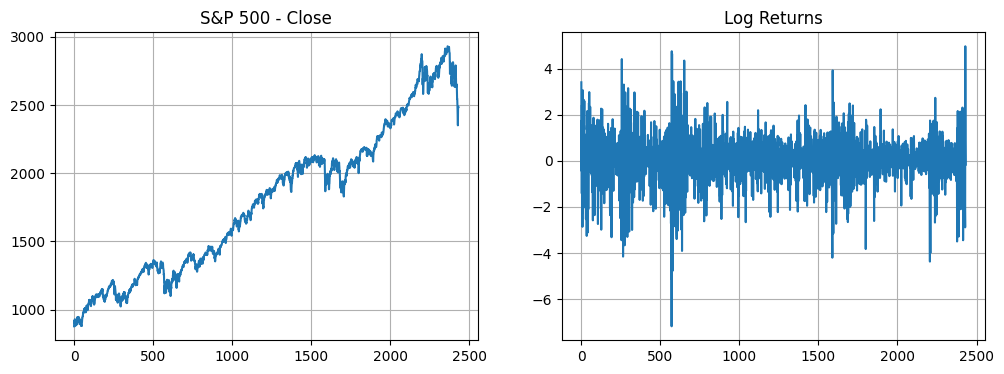

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('S&P 500 - Close')
ax[0].plot(sp500.flatten())
ax[0].grid()
ax[1].set_title('Log Returns')
ax[1].plot(sp500_lret_std.flatten())
ax[1].grid()
plt.show()

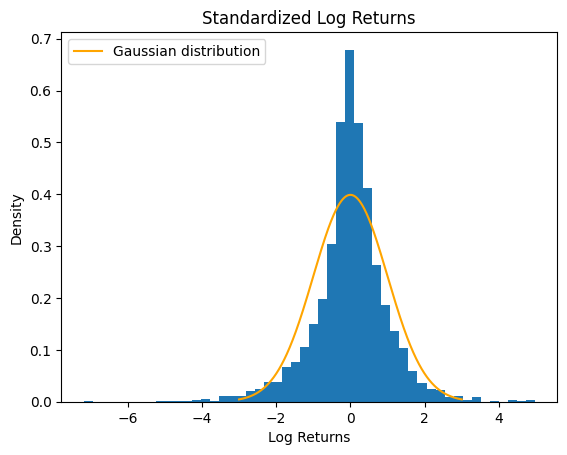

In [ ]:
plt.hist(sp500_lret_std.flatten(), bins=50, density=True)
x_axis = np.arange(-3, 3, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1) , color= 'orange')
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend(["Gaussian distribution"])
plt.title("Standardized Log Returns")
plt.show()

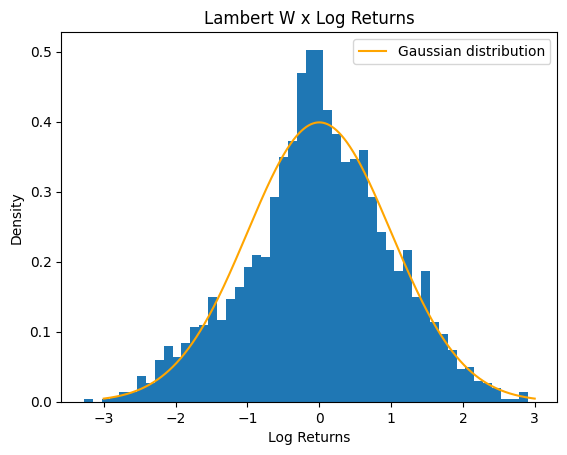

In [ ]:
plt.hist(sp500_LW_std.flatten(), bins=50, density=True)
x_axis = np.arange(-3, 3, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1) , color= 'orange')
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend(["Gaussian distribution"])
plt.title("Lambert W x Log Returns")
plt.show()

### Dataset

Dataset class for the discriminator

In [ ]:
class Dataset:
    def __init__(self, x, x_raw, device, feature_names, index):
        self.x = x
        self.x_raw = x_raw
        self.device = device
        self.feature_names = feature_names
        self.index = index

    def sample(self, batch_size):
        def get_indices(x, batch_size):
            return torch.multinomial(
                torch.arange(0, x.shape[0]).float(),
                num_samples=batch_size,
                replacement=False if x.shape[0] > batch_size else True
            )

        indices = get_indices(self.x, batch_size)
        return self.x[indices].to(self.device)

Case log returns

In [ ]:
window_size = G.receptive_field_size
# Convert numpy to torch
x_raw = torch.from_numpy(sp500_lret_std).float()
# Get matrix of input consisting of rolling windows of log-returns
x = rolling_window(x_raw, window_size)

dataset = Dataset(x, x_raw, device, feature_names, df_sp500.index)

Case Lambert W transform X log returns

In [ ]:
window_size = G.receptive_field_size
# Convert numpy to torch
x_raw = torch.from_numpy(sp500_LW_std).float()
# Get matrix of input consisting of rolling windows of log-returns
x = rolling_window(x_raw, window_size)

dataset = Dataset(x, x_raw, device, feature_names, df_sp500.index)

Functions that load the data from yahoo finance and prepare it through pipeline

## <font color="chillipepper">**Model Training**</font>

### Initialise training object


Case log returns

In [ ]:
trainer = Trainer(
        G=G,
        D=D,
        G_optimizer=G_optimizer,
        D_optimizer=D_optimizer,
        r1_gamma=0.0,
        r2_gamma=0.0,
        test_metrics=[
            # distributional test metrics
            HistoLoss(dataset.x, n_bins=200, name='abs_metric'),
            KurtosisLoss(dataset.x, name='kurtosis'),
            SkewnessLoss(dataset.x, name='skewness'),
            # dependence test metrics
            ACFLoss(dataset.x, max_lag=64, name='acf_id', threshold=0.3),
            ACFLoss(dataset.x, max_lag=64, name='acf_abs', transform=torch.abs, threshold=0.3),
            LevEffLoss(dataset.x, name='lev_eff'),
        ]
    )

Case Lambert W transform X log returns

In [ ]:
lw_inverse_transform = lambda x: pipeline.inverse_transform_torch(x)

trainer = Trainer(
        G=G,
        D=D,
        G_optimizer=G_optimizer,
        D_optimizer=D_optimizer,
        r1_gamma=0.0,
        r2_gamma=0.0,
        test_metrics=[
            # distributional test metrics
            HistoLoss(dataset.x, n_bins=200, name='abs_metric', threshold=0.3),
            KurtosisLoss(dataset.x, name='kurtosis', threshold=0.25),
            SkewnessLoss(dataset.x, name='skewness', threshold=0.3),
            # dependence test metrics
            ACFLoss(dataset.x, max_lag=64, inverse_transform=lw_inverse_transform, name='acf_id', threshold=0.15),
            ACFLoss(dataset.x, max_lag=64, name='acf_abs', inverse_transform=lw_inverse_transform, transform=torch.abs, threshold=0.15),
            LevEffLoss(dataset.x, name='lev_eff', threshold=0.3),
        ]
    )

### Train Quant GAN

In [ ]:
t_dim = G.receptive_field_size + D.receptive_field_size - 1
training_loss = defaultdict(list)

In [ ]:
time.sleep(0.2)
for G_step in tqdm(range(G_total_steps)):

    # Discriminator training step
    for _ in range(D_steps_per_G_step):
        # sample from real distribution
        x_real = dataset.sample(batch_size)
        # sample from fake latent prior distribution
        z = torch.randn(batch_size, t_dim, latent_dim).to(device)

        D_loss_real, D_loss_fake, reg_real, reg_fake = trainer.D_trainstep(x_real=x_real, z=z)

    # Generator training step
    z = torch.randn(batch_size, t_dim, latent_dim).to(device)
    G_loss, aux_losses, success = trainer.G_trainstep(z=z)
    if success:
        print('G step %d; G loss %.4f; D loss %.4f;' % (G_step+1,  training_loss['G_loss'][G_step-1], training_loss['D_loss'][G_step-1]))
        break

    # collect training losses
    training_loss['D_loss'].append(D_loss_fake + D_loss_real)
    training_loss['G_loss'].append(G_loss)
    training_loss['R1_penalty'].append(reg_real)
    training_loss['R2_penalty'].append(reg_fake)
    for name, loss in aux_losses:
        training_loss[name].append(loss)
    if (G_step+1)%(G_total_steps/20)==0:
      print('G step %d; G loss %.4f; D loss %.4f;' % (G_step+1,  training_loss['G_loss'][G_step], training_loss['D_loss'][G_step]))


  5%|▌         | 50/1000 [00:12<03:48,  4.15it/s]

G step 50; G loss 0.7181; D loss 1.3855;


 10%|█         | 100/1000 [00:24<03:35,  4.17it/s]

G step 100; G loss 0.6865; D loss 1.3811;


 15%|█▌        | 150/1000 [00:37<03:35,  3.95it/s]

G step 150; G loss 0.7046; D loss 1.3810;


 20%|██        | 200/1000 [00:50<03:45,  3.55it/s]

G step 200; G loss 0.6896; D loss 1.3782;


 25%|██▌       | 250/1000 [01:03<03:31,  3.55it/s]

G step 250; G loss 0.6913; D loss 1.3797;


 30%|███       | 300/1000 [01:16<03:21,  3.47it/s]

G step 300; G loss 0.7084; D loss 1.3774;


 35%|███▌      | 350/1000 [01:29<02:52,  3.78it/s]

G step 350; G loss 0.7003; D loss 1.3782;


 40%|████      | 400/1000 [01:42<02:38,  3.78it/s]

G step 400; G loss 0.6797; D loss 1.3809;


 45%|████▌     | 450/1000 [01:55<02:24,  3.81it/s]

G step 450; G loss 0.7224; D loss 1.3788;


 50%|█████     | 500/1000 [02:09<02:10,  3.84it/s]

G step 500; G loss 0.6792; D loss 1.3822;


 55%|█████▌    | 550/1000 [02:22<01:57,  3.84it/s]

G step 550; G loss 0.7204; D loss 1.3835;


 60%|██████    | 600/1000 [02:35<01:38,  4.06it/s]

G step 600; G loss 0.7071; D loss 1.3835;


 65%|██████▌   | 650/1000 [02:48<01:32,  3.80it/s]

G step 650; G loss 0.7023; D loss 1.3827;


 70%|███████   | 700/1000 [03:00<01:10,  4.24it/s]

G step 700; G loss 0.6932; D loss 1.3838;


 75%|███████▌  | 750/1000 [03:14<01:05,  3.79it/s]

G step 750; G loss 0.6924; D loss 1.3776;


 80%|████████  | 800/1000 [03:26<00:48,  4.11it/s]

G step 800; G loss 0.7180; D loss 1.3831;


 85%|████████▌ | 850/1000 [03:39<00:39,  3.81it/s]

G step 850; G loss 0.7195; D loss 1.3840;


 90%|█████████ | 900/1000 [03:52<00:27,  3.66it/s]

G step 900; G loss 0.6863; D loss 1.3778;


 95%|█████████▌| 950/1000 [04:06<00:14,  3.42it/s]

G step 950; G loss 0.7063; D loss 1.3787;


100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]

G step 1000; G loss 0.6829; D loss 1.3789;


Development of losses

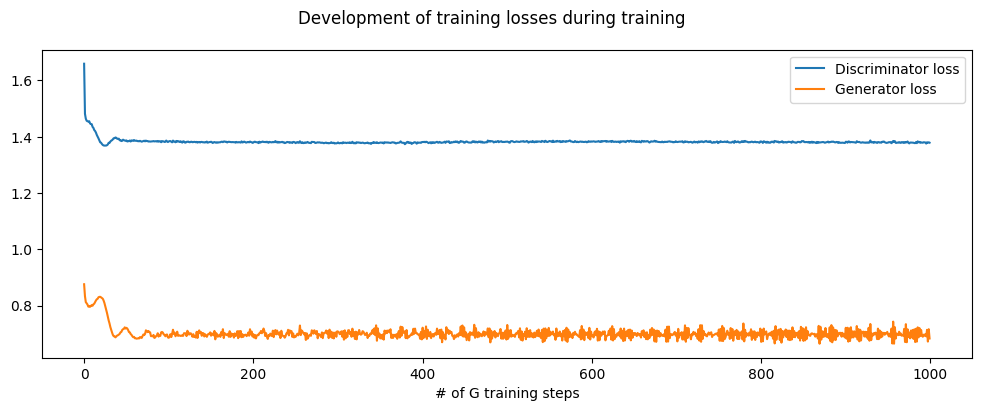

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 4))
fig.suptitle('Development of training losses during training')
ax.plot(training_loss['D_loss'], label='Discriminator loss')
ax.plot(training_loss['G_loss'], label='Generator loss')
ax.legend()
ax.set_xlabel('# of G training steps')
ax.set_xlabel('# of G training steps')
plt.show()

test metrics development

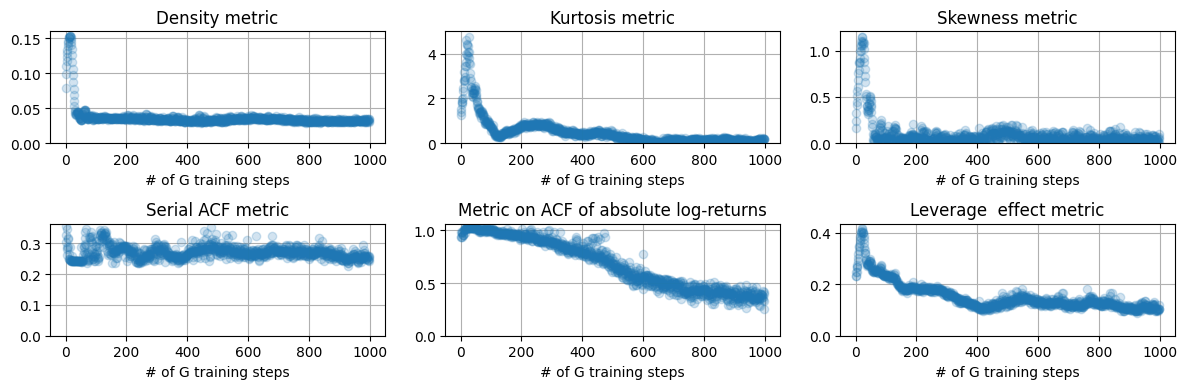

In [ ]:
ylabels = {'abs_metric': '', 'kurtosis': '', 'skewness': '',}
titles = {'abs_metric': 'Density metric', 'kurtosis':'Kurtosis metric', 'skewness':'Skewness metric',
         'acf_id': 'Serial ACF metric', 'acf_abs': 'Metric on ACF of absolute log-returns', 'lev_eff': 'Leverage  effect metric'}

fig, ax = plt.subplots(2, 3, figsize=(12, 4))
ax = ax.ravel()
for i, metric in enumerate(trainer.test_metrics):
    ax[i].plot(training_loss[metric.name], 'o', alpha=0.2)
    if metric.name in ylabels:
        ax[i].set_ylabel(ylabels[metric.name])
    ax[i].set_title(titles[metric.name])
    ax[i].set_xlabel('# of G training steps')
    ax[i].set_ylim(bottom=0.)
    ax[i].grid()
plt.tight_layout()
plt.show()

## <font color="chillipepper">**Model Evaluation**</font>

### Synthetic Data Generation


In [ ]:
t_dim_test = dataset.x_raw.shape[0]
z_test = torch.randn(100, t_dim_test+G.receptive_field_size-1, latent_dim).to(device)

Case log returns

In [ ]:
with torch.no_grad():
    x_fake = G(z_test)
    x_fake = (x_fake - x_fake.mean()) / x_fake.std()
fake_lret_std = x_fake.cpu().detach().numpy()[:,:,0].transpose()
fake_lret = Standard_scaler.inverse_transform(fake_lret_std)
fake_raw = get_raw(fake_lret)
fake_paths = fake_raw*sp500[0,0]

Case Lambert W transform X log returns

In [ ]:
with torch.no_grad():
    x_fake = G(z_test)
    x_fake = (x_fake - x_fake.mean()) / x_fake.std()

fake_LW_std = x_fake.cpu().detach().numpy()[:,:,0].transpose()
fake_lret_std = pipeline.inverse_transform(fake_LW_std)
fake_lret = Standard_scaler.inverse_transform(fake_lret_std)
fake_raw = get_raw(fake_lret)
fake_paths = fake_raw*sp500[0,0]

### Synthetic Paths

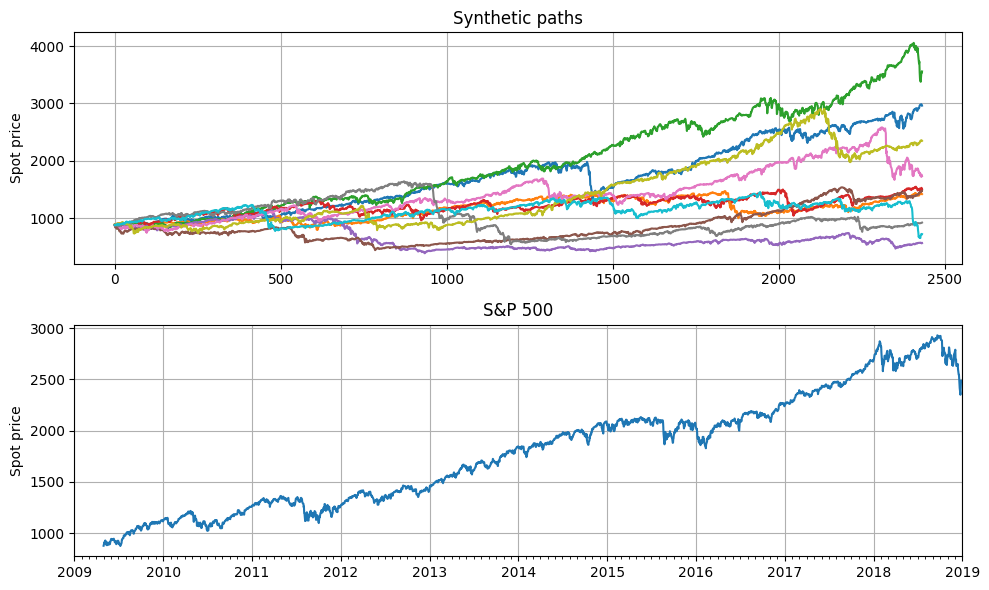

In [ ]:
index = pd.to_datetime(dataset.index)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
for path in fake_paths.transpose()[:10]:
    ax[0].plot(path.flatten(),)

ax[0].set_title('Synthetic paths')
ax[0].grid()
ax[0].set_ylabel('Spot price')
#ax[0].set_xlim(0, fake_raw.shape[1])

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ax[1].plot(index, sp500)
ax[1].xaxis.set_major_locator(years)
ax[1].xaxis.set_major_formatter(years_fmt)
ax[1].xaxis.set_minor_locator(months)
ax[1].format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax[1].format_ydata = lambda x: '$%1.2f' % x  # format the price.
datemin = np.datetime64(index[0], 'Y')
datemax = np.datetime64(index[-1], 'Y') + np.timedelta64(1, 'Y')
ax[1].set_xlim(datemin, datemax)

ax[1].set_title('S&P 500')

ax[1].grid()
ax[1].set_ylabel('Spot price')

plt.tight_layout()
plt.show()

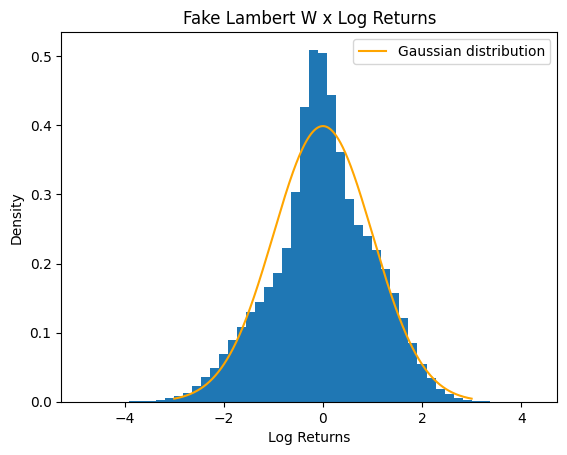

In [ ]:
plt.hist(fake_LW_std.flatten(), bins=50,density=True)
x_axis = np.arange(-3, 3, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1) , color= 'orange')
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend(["Gaussian distribution"])
plt.title("Fake Lambert W x Log Returns")
plt.show()

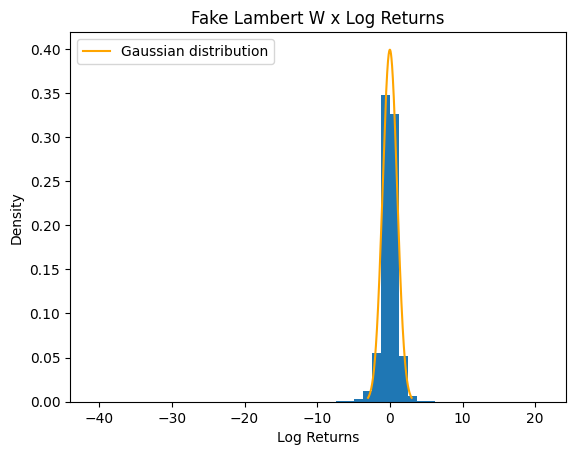

In [ ]:
plt.hist(fake_lret_std.flatten(), bins=50,density=True)
x_axis = np.arange(-3, 3, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1) , color= 'orange')
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend(["Gaussian distribution"])
plt.title("Fake Lambert W x Log Returns")
plt.show()

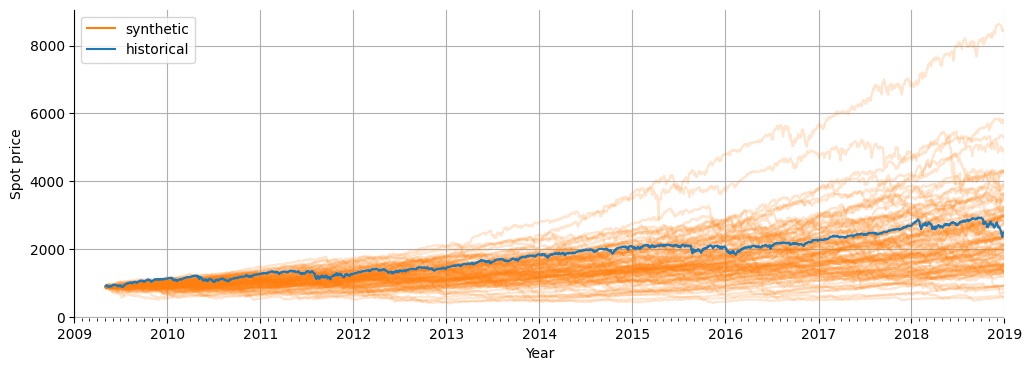

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 4))

ax.plot(index[1:], fake_paths[:,0].flatten(), color='C1', alpha=0.2, label='synthetic')
for path in fake_paths.transpose():
    ax.plot(index[1:], path.flatten(), color='C1', alpha=0.2)

ax.plot(index[1:], sp500[1:], label='historical')
ax.set_ylabel('Spot price')
ax.set_xlabel('Year')
ax.grid()
leg = ax.legend()
datemin = np.datetime64(index[0], 'Y')
datemax = np.datetime64(index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
for l in leg.get_lines():
    l.set_alpha(1)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

Compare histograms, autocorrelations!

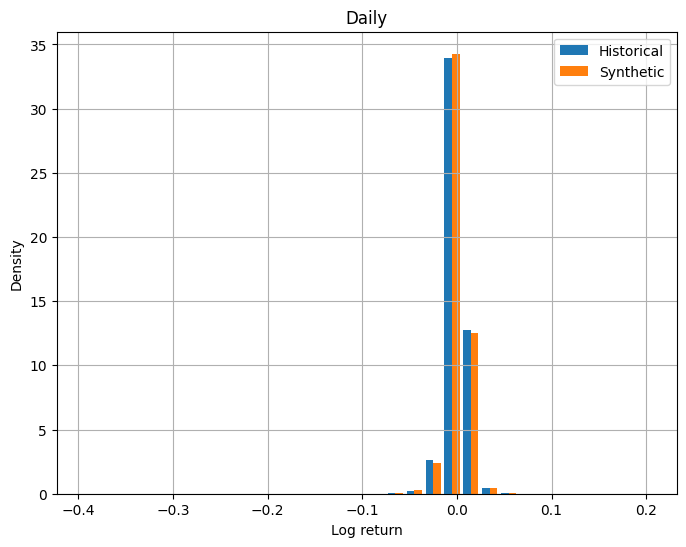

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))
ax.hist([sp500_lret.flatten(), fake_lret.flatten()], density=True, bins=30, label=['Historical', 'Synthetic'])
ax.grid()
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('Daily')
plt.show()

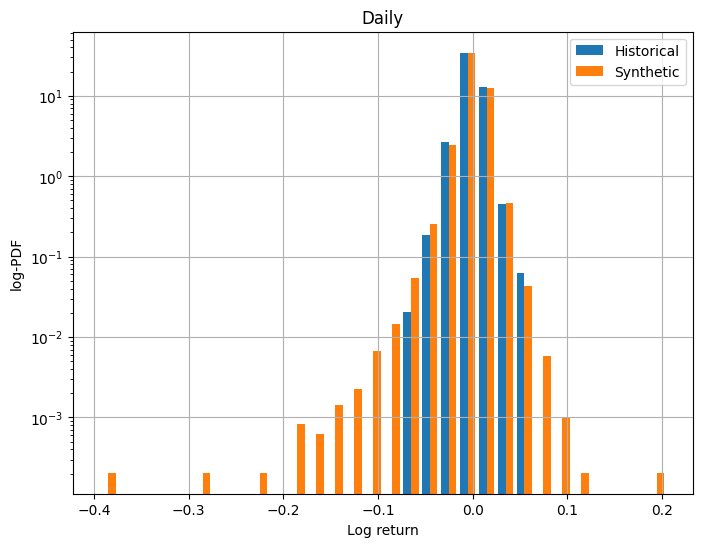

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))
ax.hist([sp500_lret.flatten(), fake_lret.flatten()], density=True, bins=30, label=['Historical', 'Synthetic'])
ax.set_ylabel('log-PDF')
ax.set_yscale('log')
ax.grid()
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('log-PDF')
plt.title('Daily')
plt.show()

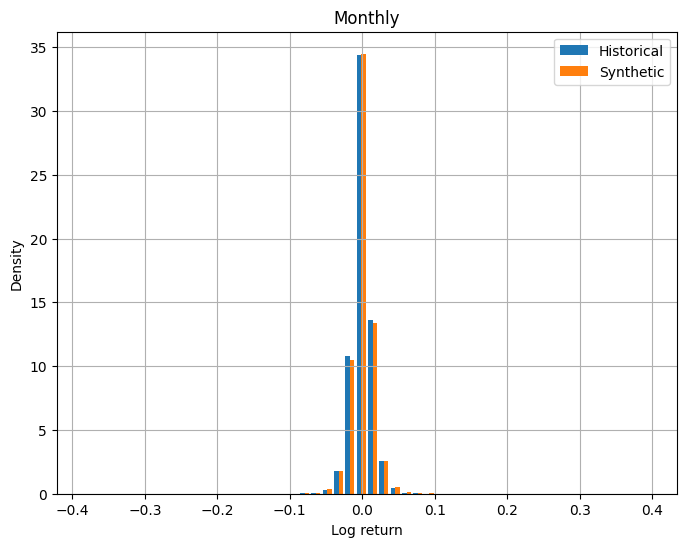

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))
ax.hist([pd.Series(sp500_lret.flatten()).diff(20).values.flatten(), pd.DataFrame(fake_lret).diff(20).values.flatten()],
        density=True, bins=50, label=['Historical', 'Synthetic'])
ax.grid()
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('Monthly')
plt.show()

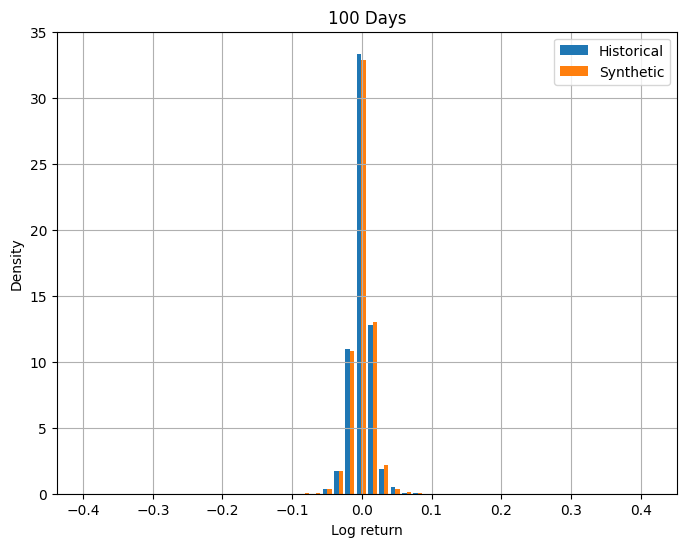

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))
ax.hist([pd.Series(sp500_lret.flatten()).diff(100).values.flatten(), pd.DataFrame(fake_lret).diff(100).values.flatten()],
        density=True, bins=50, label=['Historical', 'Synthetic'])
ax.grid()
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('100 Days')
plt.show()

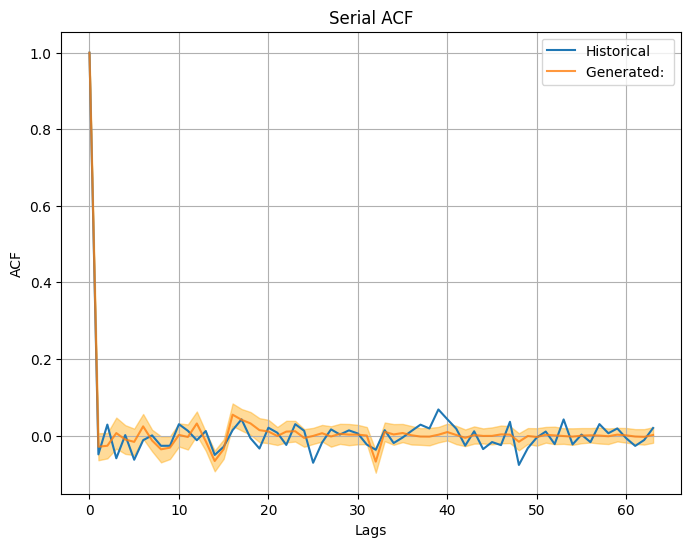

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))
acf_real_list = cacf_torch(torch.tensor(sp500_lret[None,...]).float(), max_lag=window_size, dim=(1)).cpu().numpy()
acf_real = np.mean(acf_real_list, axis=0)

acf_fake_list = cacf_torch(torch.tensor(fake_lret.transpose()[...,None]).float(), max_lag=window_size, dim=(1)).cpu().numpy()
acf_fake = np.mean(acf_fake_list, axis=0)
acf_fake_std = np.std(acf_fake_list, axis=0)

ax.plot(acf_real, label='Historical')
ax.plot(acf_fake, label='Generated: ', alpha=0.8)
ax.fill_between(range(window_size), (acf_fake-acf_fake_std).flatten(), (acf_fake+acf_fake_std).flatten(),color='orange', alpha=.4)

ax.set_xlabel('Lags')
ax.set_ylabel('ACF')
ax.grid(True)
plt.legend(loc='upper right')
plt.title('Serial ACF')
plt.show()

In [ ]:
# compute test metrics
for test_metric in trainer.test_metrics:
    print('%s: %.3f' % (test_metric.name, test_metric(torch.tensor(fake_lret[...,None]).float().cuda())))

abs_metric: 0.309
kurtosis: 26.582
skewness: 1.355
acf_id: 0.244
acf_abs: 1.024
lev_eff: 0.321


/tmp/ipython-input-340802660.py:3: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('%s: %.3f' % (test_metric.name, test_metric(torch.tensor(fake_lret[...,None]).float().cuda())))
